In [1]:
from matplotlib.pyplot import imshow
import scipy.misc
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import colorsys
import imghdr
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


### YOLO模型的输入和输出

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

### 载入YOLO模型

In [2]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [3]:
# 载入目标类别标签
class_names = read_classes("model_data/coco_classes.txt")
print(class_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
# 载入Anchor Box类型
anchors = read_anchors("model_data/yolo_anchors.txt")
print(anchors)

[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


In [5]:
# 载入训练好的YOLO模型
yolo_model = load_model("model_data/yolo.h5")

D:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# YOLO模型结构
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

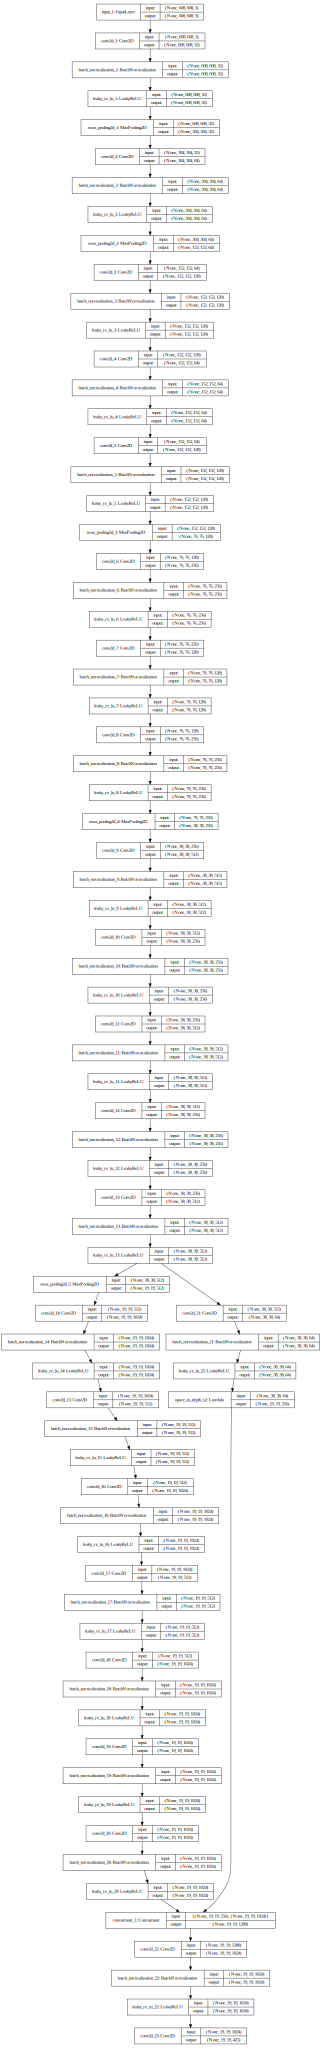

In [7]:
# YOLO模型结构图
SVG(model_to_dot(yolo_model, show_shapes=True).create(prog='dot', format='svg'))

### 定义Bounding Box过滤函数

In [8]:
# Filters YOLO boxes by thresholding on object and class confidence.
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores > threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [9]:
# Applies Non-max suppression (NMS) to set of boxes
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [10]:
# Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
def yolo_eval(yolo_outputs, max_boxes=10, score_threshold=.6, iou_threshold=.5):
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

### 转换YOLO模型的输出

yolo_model.input ==> yolo_model.output ==> yolo_outputs ==> (scores, boxes, classes)

In [11]:
yolo_model.input

<tf.Tensor 'input_1:0' shape=(?, 608, 608, 3) dtype=float32>

In [12]:
yolo_model.output

<tf.Tensor 'conv2d_23/BiasAdd:0' shape=(?, 19, 19, 425) dtype=float32>

In [13]:
# Convert final layer features to bounding box parameters.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
yolo_outputs

(<tf.Tensor 'Sigmoid:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
 <tf.Tensor 'truediv:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_1:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'Reshape_6:0' shape=(?, ?, ?, 5, 80) dtype=float32>)

In [14]:
scores, boxes, classes = yolo_eval(yolo_outputs)
scores, boxes, classes

(<tf.Tensor 'embedding_lookup:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'embedding_lookup_1:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'embedding_lookup_2:0' shape=(?,) dtype=int64>)

### 预测结果绘制函数

In [15]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

In [16]:
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [17]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [18]:
# Scales the predicted boxes in order to be drawable on the image
def scale_boxes(boxes, image_size):
    width = image_size[0]
    height = image_size[1]
    boxes = boxes * [height, width, height, width]
    return boxes

In [19]:
# Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
def predict(sess, image_file):
    # Preprocess your image
    image, image_data = preprocess_image(os.path.join("images", image_file), model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    out_scores, out_boxes, out_classes = sess.run((scores, boxes, classes), 
                                                  feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    # Scale boxes back to original image shape.
    out_boxes = scale_boxes(out_boxes, image.size)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

### 对图片进行目标检测

In [20]:
sess = K.get_session()

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


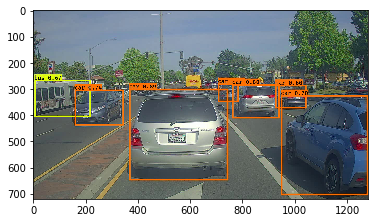

In [21]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 2 boxes for giraffe.jpg
zebra 0.83 (241, 208) (422, 442)
giraffe 0.89 (166, 0) (439, 448)


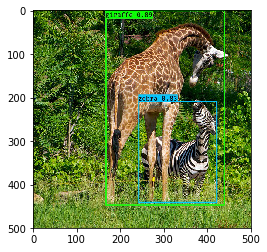

In [22]:
out_scores, out_boxes, out_classes = predict(sess, "giraffe.jpg")

Found 3 boxes for food.jpg
diningtable 0.71 (0, 0) (450, 320)
fork 0.77 (29, 218) (198, 284)
knife 0.79 (235, 190) (309, 320)


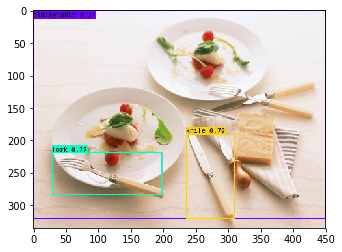

In [23]:
out_scores, out_boxes, out_classes = predict(sess, "food.jpg")